# For now, this notebook is basically a copy of the TESS transit fitting case study found [here](https://gallery.exoplanet.codes/en/latest/tutorials/quick-tess/)

.. note:: You will need exoplanet version 0.2.6 or later to run this tutorial.

In this tutorial, we will fit the TESS light curve for a known transiting planet. While the Fitting TESS data case study goes through the full details of an end-to-end fit, this tutorial is significantly faster to run and it can give pretty excellent results depending on your goals. Some of the main differences are:

    We start from the light curve rather than doing the photometry ourselves. This should pretty much always be fine unless you have a very bright, faint, or crowded target.
    We assume a circluar orbit, but as you’ll see later, we can approximately relax this assumption later.
    We only fit the data near transit. In many cases this will be just fine, but if you have predictable stellar variability (like coherent rotation) then you might do better fitting more data.

We’ll fit the planet in the HD 118203 (TIC 286923464) system that was found to transit by Pepper et al. (2019) because it is on an eccentric orbit so assumption #2 above is not valid.

First, let’s download the TESS light curve using lightkurve:

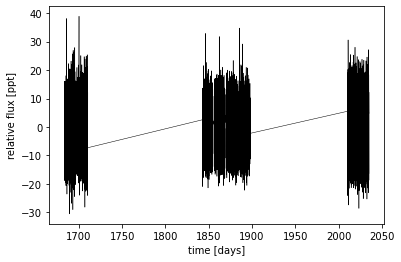

In [6]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

lcfs = lk.search_lightcurvefile("TIC 198485881", mission="TESS").download_all()
lc = lcfs.PDCSAP_FLUX.stitch()
lc = lc.remove_nans().remove_outliers(sigma=7)

x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (lc.flux - 1), dtype=np.float64)
yerr = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

texp = np.min(np.diff(x))

plt.plot(x, y, "k", linewidth=0.5)
plt.xlabel("time [days]")
_ = plt.ylabel("relative flux [ppt]")

Then, find the period, phase and depth of the transit using box least squares:

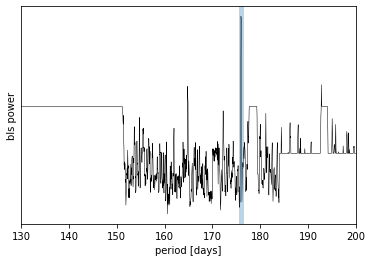

In [9]:
import exoplanet as xo

pg = xo.estimators.bls_estimator(x, y, yerr, min_period=130, max_period=200)

peak = pg["peak_info"]
period_guess = peak["period"]
t0_guess = peak["transit_time"]
depth_guess = peak["depth"]

plt.plot(pg["bls"].period, pg["bls"].power, "k", linewidth=0.5)
plt.axvline(period_guess, alpha=0.3, linewidth=5)
plt.xlabel("period [days]")
plt.ylabel("bls power")
plt.yticks([])
_ = plt.xlim(pg["bls"].period.min(), pg["bls"].period.max())

Then, for efficiency purposes, let’s extract just the data within 0.25 days of the transits:

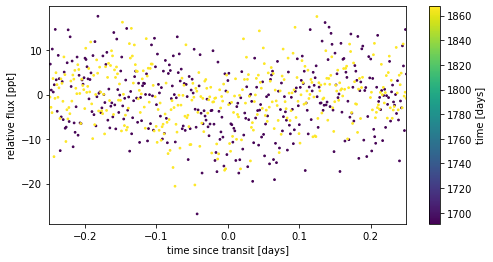

In [10]:
transit_mask = (
    np.abs(
        (x - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess
    )
    < 0.25
)
x = np.ascontiguousarray(x[transit_mask])
y = np.ascontiguousarray(y[transit_mask])
yerr = np.ascontiguousarray(yerr[transit_mask])

plt.figure(figsize=(8, 4))
x_fold = (
    x - t0_guess + 0.5 * period_guess
) % period_guess - 0.5 * period_guess
plt.scatter(x_fold, y, c=x, s=3)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
_ = plt.xlim(-0.25, 0.25)

# The probabilistic model

Here’s how we set up the PyMC3 model in this case:

In [13]:
import pymc3 as pm
import theano.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess


with pm.Model() as model:

    # Stellar parameters
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)
    u = xo.QuadLimbDark("u")
    star_params = [mean, u]

    # Gaussian process noise model
    sigma = pm.InverseGamma("sigma", alpha=3.0, beta=2 * np.median(yerr))
    sigma_gp = pm.Lognormal("sigma_gp", mu=0.0, sigma=10.0)
    rho_gp = pm.Lognormal("rho_gp", mu=np.log(10.0), sigma=10.0)
    kernel = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1.0 / 3)
    noise_params = [sigma, sigma_gp, rho_gp]

    # Planet parameters
    ror = pm.Lognormal("ror", mu=0.5 * np.log(depth_guess * 1e-3), sigma=10.0)

    # Orbital parameters
    period = pm.Lognormal("period", mu=np.log(period_guess), sigma=1.0)
    t0 = pm.Normal("t0", mu=t0_guess, sigma=1.0)
    dur = pm.Lognormal("dur", mu=np.log(0.1), sigma=10.0)
    b = xo.distributions.ImpactParameter("b", ror=ror)

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(period=period, duration=dur, t0=t0, b=b)

    # We're going to track the implied density for reasons that will become clear later
    pm.Deterministic("rho_circ", orbit.rho_star)

    # Set up the mean transit model
    star = xo.LimbDarkLightCurve(u)

    def lc_model(t):
        return mean + 1e3 * tt.sum(
            star.get_light_curve(orbit=orbit, r=ror, t=t), axis=-1
        )

    # Finally the GP observation model
    gp = GaussianProcess(
        kernel, t=x, diag=yerr ** 2 + sigma ** 2, mean=lc_model
    )
    gp.marginal("obs", observed=y)

    # Double check that everything looks good - we shouldn't see any NaNs!
    print(model.check_test_point())

    # Optimize the model
    map_soln = model.test_point
    map_soln = pmx.optimize(map_soln, [sigma])
    map_soln = pmx.optimize(map_soln, [ror, b, dur])
    map_soln = pmx.optimize(map_soln, noise_params)
    map_soln = pmx.optimize(map_soln, star_params)
    map_soln = pmx.optimize(map_soln)

mean                  -3.22
u_quadlimbdark__      -2.77
sigma_log__           -0.53
sigma_gp_log__        -3.22
rho_gp_log__          -3.22
ror_log__             -3.22
period_log__          -0.92
t0                    -0.92
dur_log__             -3.22
b_impact__            -1.39
obs                -2430.84
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [sigma]


message: Optimization terminated successfully.
logp: -2453.4831855059742 -> -2428.614397634438
optimizing logp for variables: [dur, b, ror]


message: Optimization terminated successfully.
logp: -2428.614397634438 -> -2420.7509768283885
optimizing logp for variables: [rho_gp, sigma_gp, sigma]


message: Optimization terminated successfully.
logp: -2420.7509768283885 -> -2420.6307456458544
optimizing logp for variables: [u, mean]


message: Optimization terminated successfully.
logp: -2420.6307456458544 -> -2419.8036615197057
optimizing logp for variables: [b, dur, t0, period, ror, rho_gp, sigma_gp, sigma, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -2419.8036615197057 -> -2409.54666492523


Now we can plot our initial model:

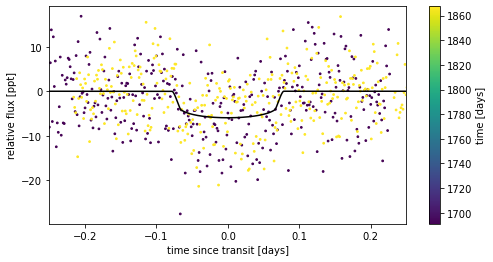

In [14]:
with model:
    gp_pred, lc_pred = xo.eval_in_model(
        [gp.predict(y, include_mean=False), lc_model(x)], map_soln
    )

plt.figure(figsize=(8, 4))
x_fold = (x - map_soln["t0"] + 0.5 * map_soln["period"]) % map_soln[
    "period"
] - 0.5 * map_soln["period"]
inds = np.argsort(x_fold)
plt.scatter(x_fold, y - gp_pred - map_soln["mean"], c=x, s=3)
plt.plot(x_fold[inds], lc_pred[inds] - map_soln["mean"], "k")
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
_ = plt.xlim(-0.25, 0.25)

Now on to sampling:

In [15]:
np.random.seed(286923464)
with model:
    trace = pmx.sample(
        tune=2000, draws=2000, start=map_soln, chains=2, cores=2
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, dur, t0, period, ror, rho_gp, sigma_gp, sigma, u, mean]


TypeError: cannot pickle 'exoplanet.theano_ops.driver.LimbDark' object